# Divisive gating
Testing divisive clustering on data from an fcs file chosen randomly form cytobank. 

In [1]:
from divisivegater.gater import Gater
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from os import walk
from itertools import cycle, islice
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

Make a gater object and specify path to the fcs file

In [2]:
gater = Gater(distance_function='supremum_distance', cone_solver='glpk')

# good alternatives are

# gater = Gater(distance_function='wasserstein_distance')

# or 

# from divisivegater.cover import Cover, plotX, wasserstein_distance
# gater = Gater(distance_function=wasserstein_distance(p=3))

Read in file to the Gater object

In [3]:
filenames = '../rawdata/140910 CyTOF06 Run 1 MF5 Basal 1_1.fcs'
gater.read_fcs_file(filenames)

List all markers in the fcs file

In [4]:
gater.get_all_markers()

Index(['BKGD', 'Ba138Di', 'CD11b', 'CD11c', 'CD123', 'CD14', 'CD19', 'CD235',
       'CD3', 'CD33', 'CD34', 'CD38', 'CD45', 'CD45RA', 'CD61', 'CD66a',
       'CD71', 'CD90', 'Cisplatin', 'Cs133Di', 'DNA1', 'DNA2', 'EQ1',
       'Event_length', 'HLA-DR', 'Ki67', 'Pb208Di', 'Pt194Di', 'Pt196Di',
       'Time', 'Xe131Di', 'p-p38', 'p-p65-NFkB', 'pAKT', 'pCREB', 'pEGFR',
       'pERK', 'pS6', 'pSTAT1', 'pSTAT3', 'pSTAT5', 'tIKBa'],
      dtype='object')

Show the shape of the fcs file. 

In [5]:
gater.data.shape

(51181, 42)

Specify the markers used to form clusters. (Everything except 'Time'. You might prefer to use only lineage markers. This is just a demonstration.)

In [6]:
gater.set_markers([
    'BKGD', 'Ba138Di', 'CD11b', 'CD11c', 'CD123', 'CD14', 'CD19', 'CD235',
    'CD3', 'CD33', 'CD34', 'CD38', 'CD45', 'CD45RA', 'CD61', 'CD66a',
    'CD71', 'CD90', 'Cisplatin', 'Cs133Di', 'DNA1', 'DNA2', 'EQ1',
    'Event_length', 'HLA-DR', 'Ki67', 'Pb208Di', 'Pt194Di', 'Pt196Di',
    'Xe131Di', 'p-p38', 'p-p65-NFkB', 'pAKT', 'pCREB', 'pEGFR',
    'pERK', 'pS6', 'pSTAT1', 'pSTAT3', 'pSTAT5', 'tIKBa'
], scale=True, reducer=None)

In [7]:
X = gater.X
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=min(X.shape), 
          whiten=False).fit(X)
gater.X = pca.transform(X)

Dependent on the number of clusters, list how many outliers there will be. We want to have few outliers and enough clusters. We plot a bar chart of the number of outliers with respect to the number of clusters.

CPU times: user 42 s, sys: 7.76 s, total: 49.8 s
Wall time: 36.2 s


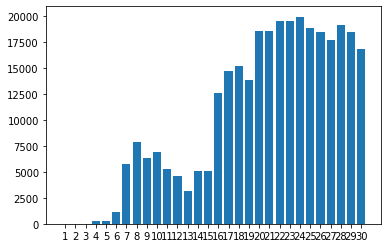

In [8]:
%%time
N = 30
outlier_lengths = {}
for n_components in range(1, N + 1):
    outlier_lengths[n_components] = len(gater.components(n_components=n_components)[-1])

plt.bar(np.arange(len(outlier_lengths)), outlier_lengths.values())
plt.xticks(np.arange(0, len(outlier_lengths)), np.arange(1, len(outlier_lengths) + 1));

In [20]:
n_clusters = 13

We save the clusters for later use. It seems around 10 is generally a good number of clusters.

In [21]:
cluster_list = gater.cluster_list(n_clusters=n_clusters)
clusters = [np.flatnonzero(cluster_list == value) for value in range(n_clusters)]

We also save the division into conponents and outliers.

In [22]:
components = gater.components(n_components=n_clusters)
component_list = np.empty(len(gater.X), dtype=int)
for idx, component in enumerate(components):
    component_list[component] = idx

Select what kind of 'components' to work with. Either 'components' or 'clusters'.

In [23]:
comps = components

Set color palette

In [24]:
colors = np.vstack((plt.cm.tab10(np.arange(10)), plt.cm.Set3(np.arange(12))))
colors = np.array(list(islice(cycle(colors), n_clusters)))
colors = np.vstack((colors, [0,0,0,1]))

Bar plot of sizes of clusters

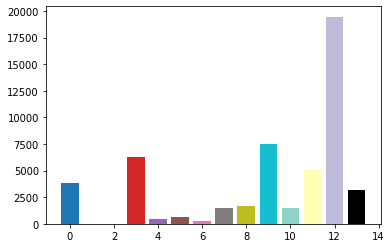

In [25]:
for idx, comp in enumerate(comps):
    height = np.zeros(len(comps))
    height[idx] = len(comp)
    plt.bar(np.arange(len(comps)), height=height, color=colors[idx])

Produce TSNE embedding of a sample of the data containing 10.000 events

In [15]:
sample = np.random.choice(np.arange(len(gater.X)), size=10000)
Y = TSNE(n_components=2, perplexity=30).fit_transform(gater.X[sample])

Plot the clusters on the TSNE embedding. The outliers are black.

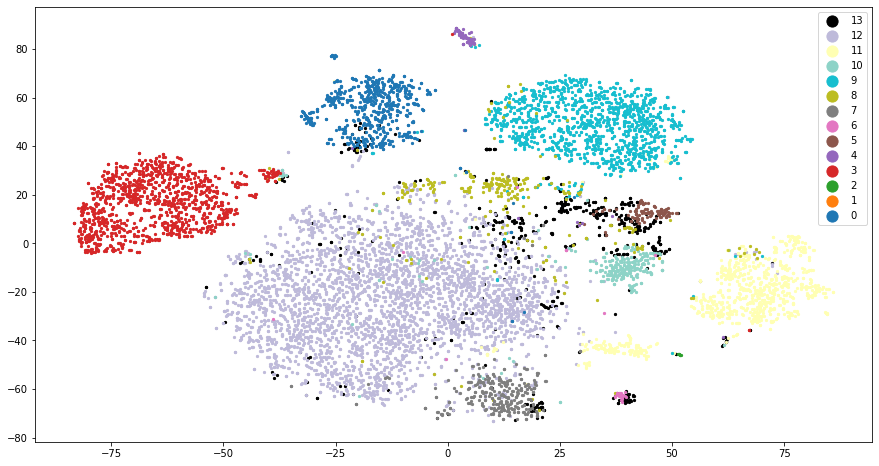

In [26]:
plt.figure(figsize=(15,8))
for idx, component in list(enumerate(components))[::-1]:
    comp = np.isin(sample, component)
    plt.scatter(Y[comp, 0], Y[comp, 1], s=5, color=colors[idx], label=idx)
# Plot legend.
lgnd = plt.legend(scatterpoints=1, fontsize=10, markerscale=5)

Plot cleaning channels of the clusters. Note that the last black row is a plot of the outliers.

Compare to **flowsom** at [bioconductor](https://www.bioconductor.org/help/course-materials/2017/BioC2017/Day2/Workshops/CyTOF/doc/cytofWorkflow_BioC2017workshop.html)

It may be hard to distinguish the colors, so we make one small plot for each refined cluster.


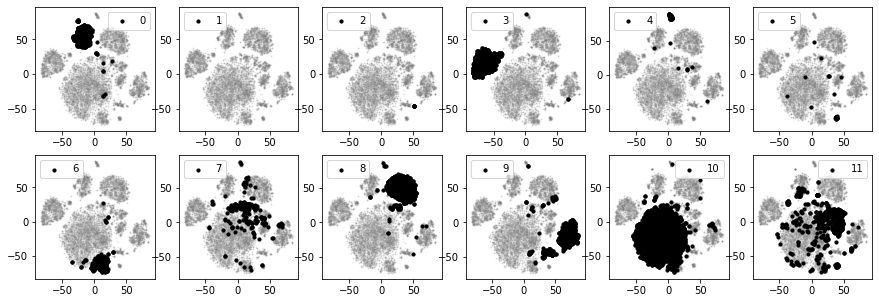

In [17]:
plot_columns = 6
plot_rows = np.ceil(len(comps) / plot_columns)
figsize = (15, (15 / plot_columns) * plot_rows)
plt.figure(figsize=figsize)
n = 0
for idx, comp in enumerate(comps):
    if len(comp) == 0:
            continue
    plt.subplot(plot_rows, plot_columns, n+1)
    plt.scatter(Y[:, 0], Y[:, 1], color='grey', s=1, alpha=0.1)
    comp = np.isin(sample, comp)
    plt.scatter(Y[comp, 0], Y[comp, 1], s=10, color='black', label=n)
    n += 1
    plt.legend()        

In [27]:
plot_components = np.arange(len(comps))

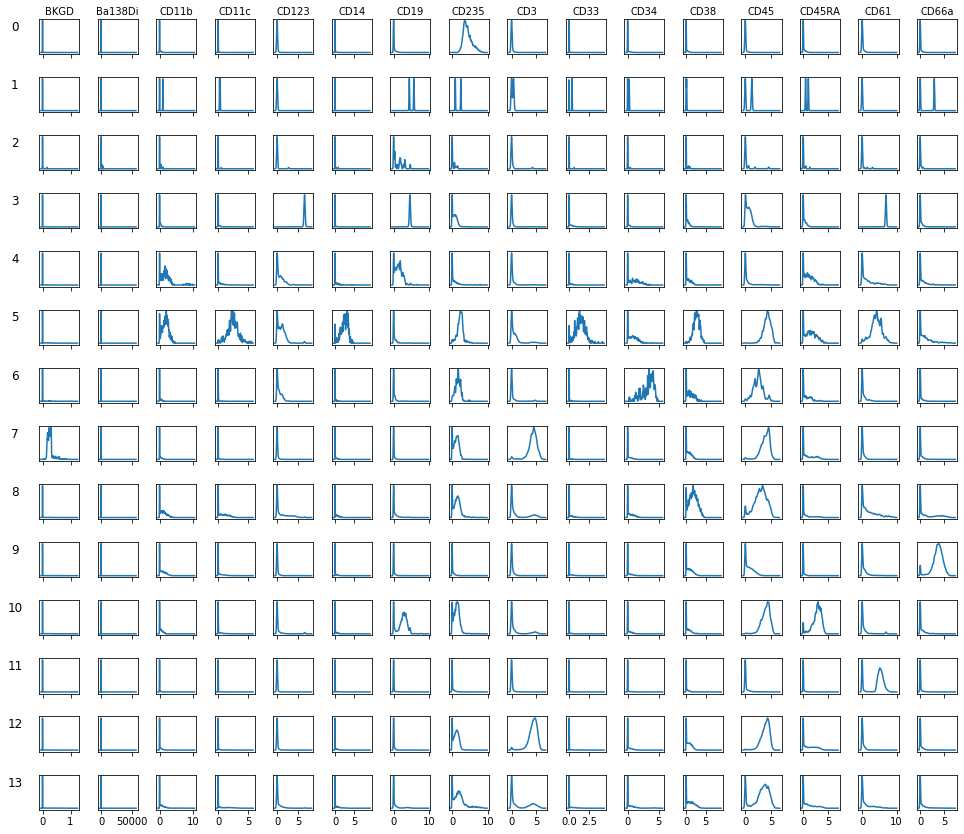

In [28]:
gater.plot_intensities(
    components=plot_components,
    colors=colors,
    cmap='jet',
    plot_columns=16,
    comps=comps,
    markers=[
        'BKGD', 'Ba138Di', 'CD11b', 'CD11c', 'CD123', 'CD14', 'CD19', 'CD235',
        'CD3', 'CD33', 'CD34', 'CD38', 'CD45', 'CD45RA', 'CD61', 'CD66a',
    ],
    KDE=True,
    bandwidth=0.05,
    ticks=True
);

In [ ]:
gater.plot_intensities(
    components=plot_components,
    colors=colors,
    cmap='jet',
    plot_columns=16,
    comps=comps,
    markers=[
        'CD71', 'CD90', 'Cisplatin', 'Cs133Di', 'DNA1', 'DNA2', 'EQ1',
        'Event_length', 'HLA-DR', 'Ki67', 'Pb208Di', 'Pt194Di', 'Pt196Di',
    ],
    KDE=True,
    bandwidth=0.05,
    ticks=True
);

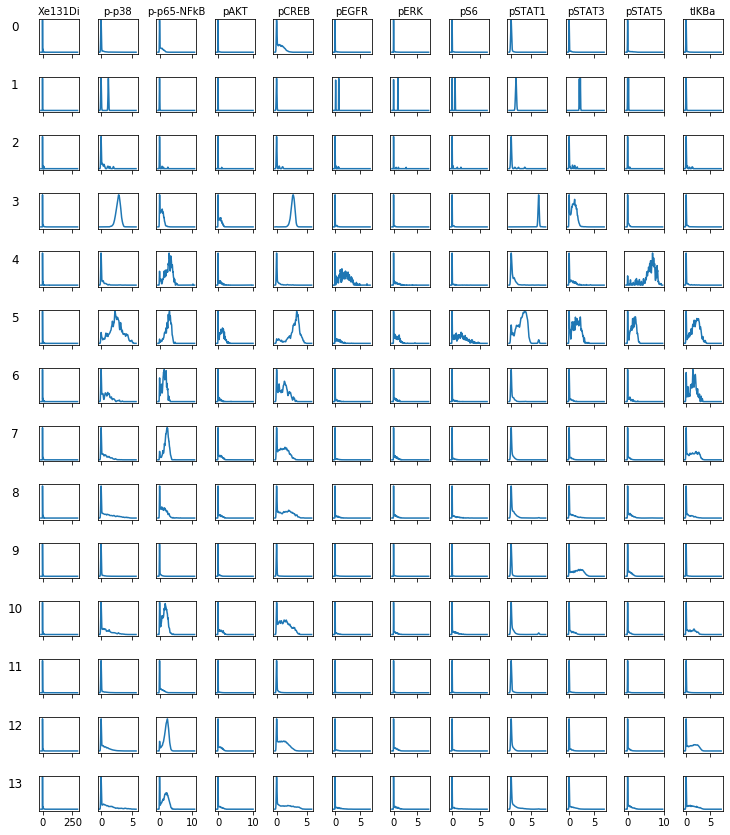

In [29]:
gater.plot_intensities(
    components=plot_components,
    colors=colors,
    cmap='jet',
    plot_columns=16,
    comps=comps,
    markers=[        
        'Xe131Di', 'p-p38', 'p-p65-NFkB', 'pAKT', 'pCREB', 'pEGFR',
        'pERK', 'pS6', 'pSTAT1', 'pSTAT3', 'pSTAT5', 'tIKBa'
    ],
    KDE=True,
    bandwidth=0.05,
    ticks=True
);